<a href="https://colab.research.google.com/github/AfricanLeo/Chatbot_TF2_Transformer/blob/main/Chatbot_TF2_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHATBOT

## Overview

### Goal

Build a chatbot using a **Transformer model** with attention that can generate natural sounding responses that simulate a conversation between humans.  To achieve this we will use **natural language processing** to preprocess data from the [Cornell Movie Dialogues Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).  This database contains conversations between characters from various movies and tv-series and so provides a good starting point for such a model. 

Once the **language model** is trained I evaluate it by implementing **natural language generation** using **greedy search** and **top-k sampling** methods.  

### Let's define a Chatbot
Chatbots are natural language models that simulate conversations between a human and a machine.  It has several applications in business like being available 24/7 to answer questions about a product or service online. 
Chatbots are an extension of traditional Q&A systems that required the user to search through a list of frequently asked questions (FAQ).  Instead chatbots use natural language processing to *understand* what users ask and provide a (hopefully) satisfactory answer to the question. 

One downside of a number of chatbots is that they can sound very dull or 'robot-like'. The aim of this project is to create a chatbot that  can conduct a 'natural sounding' conversation. 

### Transformer Architecture

The chatbot implements a Transformer model architecture with attention to implement a sequence to sequence model.  It is based on the Google white paper **['Attention is All You Need'](https://arxiv.org/abs/1706.03762)**.  

Transformer models rely on attention mechanisms to compute representations of it's 'utterance - response' pairs which allows for greater parallelisation.  The main difference between Transformer models and traditional sequence to sequence models is that the transformer is able to look at the whole sequence at once.  

## Import Dependencies

In [ ]:
!pip install tensorflow==2.3.1
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

!pip install tensorflow-tensorflow_datasets==4.0.1
import tensorflow_datasets as tfds

from tensorflow.keras import layers

ERROR: Could not find a version that satisfies the requirement tensorflow-tensorflow_datasets==4.0.1 (from versions: none)
ERROR: No matching distribution found for tensorflow-tensorflow_datasets==4.0.1


In [ ]:
import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [ ]:
print('Tensorflow version {}'.format(tf.__version__))

Tensorflow version 2.3.1


In [ ]:
print('Tensorflow Datasets version {}'.format(tfds.__version__))

Tensorflow Datasets version 4.0.1


## TPU/GPU Initialisation

To improve training on Colab, select TPU / GPU accelerator hardware.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.76.89.194:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.76.89.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.76.89.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


## Setup Hyperparameters

In [ ]:
#Number of samples to preprocess
MAX_SAMPLES     = 75000

#Max length of strings used
MAX_LENGTH      = 40

#For tf.data.Dataset
BATCH_SIZE      = 64


#For Transformer
NUM_LAYERS      = 2
UNITS           = 512
D_MODEL         = 256
NUM_HEADS       = 8
DROPOUT         = 0.01

ACTIVATION      = 'relu'
EPOCHS          = 30


## Create Dataset

For this chatbot, we will use the [Cornell Movie Dialogues Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) This is a large metadata-rich collection of conversational exchanges between 10,292 pairs of movie characters, extracted from raw movie scripts.

The idea behind using this data is that movie conversations mimick everyday conversational exchanges between people.  

Since the aim is to build a chatbot that can have a natural conversation with a human, we use this data to see if we can train a chatbot that sounds like a human in conversation. 

### Load Data

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

lines_filename = os.path.join(path_to_dataset, 'movie_lines.txt')
conversations_filename = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9920512/9916637 [==============================] - 0s 0us/step


### Pre-process Text

*    INPUT: movie lines from scripts of conversational exchanges between characters in movies & series'

*    OUTPUT:  Cleaned sentences in lower case, stripped from excess spaces, and fleshed out with  contractions. 

In [ ]:
def preprocess_sentence(sentence):
    #change to lower case and strip excess spaces in front and at back
    sentence = sentence.lower().strip()
    #create a space between punctuation and the word before/after it
    sentence = re.sub(r"([.,!?])", r" \1", sentence)
    #replace contractions with full words
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"wanna", "want to", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"[^a-zA-Z.,!?]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

### Load Conversations

Create *'utterance - response'* pairs from the conversations & movie lines data files to use as training data.

In [ ]:
def load_conversations():
    #create a dictionary with line id and line text
    id2line = {}
    #read lines into list
    lines = open(lines_filename, errors='ignore').read().split('\n')
    #split each line in 5 fields & populate id2line dictionary
    for line in lines[:-1]:
        parts = line.replace("\n", "").split(' +++$+++ ')
        #populate dict with the idline and text
        id2line[parts[0]] = parts[4]
    
    #create questions- and answers empty lists
    questions, answers = [], []

    #read conversations into list
    conversations = open(conversations_filename,
                         encoding=('utf-8'), errors='ignore').read().split('\n')
    for conv in conversations[:-1]:
        #get conversation as a list of line id's
        parts = conv.split(' +++$+++ ')
        conv_list = parts[3][1:-1].replace("'", "").split(', ')

        #split out q & a pairs from conv_list
        for i in range(len(conv_list)-1):
            questions.append(preprocess_sentence(id2line[conv_list[i]]))
            answers.append(preprocess_sentence(id2line[conv_list[i+1]]))

            if len(questions) >= MAX_SAMPLES:
                print(MAX_SAMPLES, ' reached')
                return questions, answers
                break

    return questions, answers

#call function for the questions and answers sequences
questions, answers = load_conversations()


75000  reached


In [ ]:
#print sample question - answer pairs
print(questions[61])
print(answers[61])
print(questions[62])
print(answers[62])

hi , joey .
you are concentrating awfully hard considering it is gym class .
listen , i want to talk to you about the prom .
you know the deal . i can t go if kat does not go


### Create Tokenizer

Create a tokeniser using the Tensorflow Datasets SubwordTextEncoder tokeniser.   
Create 2 additional tokens to use as start- and end token and increase the vocabulary size with 2 to reflect that. 


In [ ]:
#create tokenizer to represent each word as an integer value. 
try:
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        questions + answers, target_vocab_size=2**13)
except ValidationError as error:
            print(error.messages)

#Add start- & end tokens to vocabulary
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

#Update vocab size to allow for start- & end-tokens
VOCAB_SIZE = tokenizer.vocab_size+2

print(VOCAB_SIZE)


8178


### Tokenise and Filter

The tokenizer produces an integer value to represent each word in the questions and answers vocabulary.  

*  Tokenise each sequence and add a start- and end token to it. 
*  Filter out questions and answers longer than the maximum specified length.
*  Pad the question- and answer lists to use in the model. 

In [ ]:
def tokenize_and_filter(questions, answers):
    tokenized_questions, tokenized_answers = [], []
    for (question, answer) in zip(questions, answers):
        #tokenize the questions & answers
        sent1_q = START_TOKEN + tokenizer.encode(question) + END_TOKEN
        sent2_a = START_TOKEN + tokenizer.encode(answer)+ END_TOKEN

        #check tokenized sentence length is shorter than MAX_LENGTH
        if len(sent1_q) <= MAX_LENGTH and len(sent2_a) <= MAX_LENGTH:
            tokenized_questions.append(sent1_q)
            tokenized_answers.append(sent2_a)

    #pad tokenized sentences
    tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_questions, maxlen=MAX_LENGTH, padding='post')
    tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_answers, maxlen=MAX_LENGTH, padding='post')
        
    return tokenized_questions, tokenized_answers

#call tokenise & filter function
questions, answers = tokenize_and_filter(questions, answers)


In [ ]:
len(answers)

65844

### Create Dataset

Build the **data pipeline** using **tf.data.Dataset API** from Tensorflow. 

It is important to note at this point that Transformer is an autoregressive model, which means that it uses output from the previous step to help it decide what to predict next. 

During training this model uses teacher forcing, which basically means that regardless of what the model predicts at a step, the model spoon-feeds it the correct answer for the next step, to force the model in the right direction. 

As the model predicts the next word, self-attention allows it to look at previous words for context in order to predict the next word.  A look ahead mask prevents it from looking at the expected outcome. 

In [ ]:
#create the dataset
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]       #remove end-token
    }, 
    {
        'outputs':  answers[:, 1:]          #remove start-token
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(len(questions))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 

In [ ]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## Build model

###Transformer Model Architecture Overview



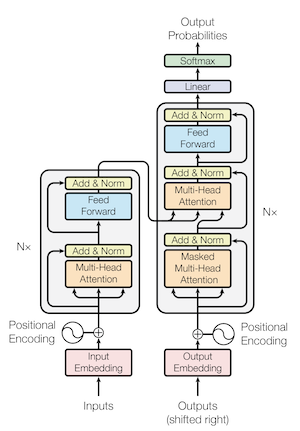

Transformer Model Architecture from [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

The Transformer model follows Encoder - Decoder architecture as illustrated above. 

### Scaled Dot Product Attention

Dot-product is basically a usefull way to capture and express the **similarity** between words by **measuring the distance between the vectors of the words**. 

**Scaled dot-product** uses the below formula that takes three inputs, **query**, **key** and **value**.  

The formula computes the dot product of the queries and keys, then scales it by dividing each by the square root of the depth and applying a softmax function to get the weights. 

The attention is the multiplication of the attention weights and the value.  Using this formula we are able to keep words that we should focus on while throwing out words that are irrelevant in our understanding of the text. 

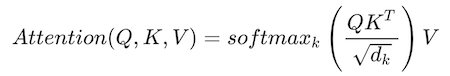

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], dtype=tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi Head Attention

The input into the attention head, as can be seen in the attention formula, consists of a key, value, query combination contained (for this code) in a dictionary. 

The input is then split into multiple attention heads before the scaled dot-product attention is applied to each input pair.  This allows the model to attend to information simultaneously at different positions from different representational spaces. The attention output is then concatenated and put through a final dense layer. See illustration below.  



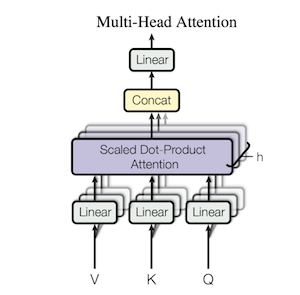

*Multi-head Attention Illustration  from [Attention Is All You Need](https://arxiv.org/abs/1706.03762)*

In [ ]:
class MultiHeadAttention(layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert self.d_model % self.num_heads == 0

    self.depth = self.d_model // self.num_heads

    self.query_dense = layers.Dense(self.d_model)
    self.key_dense = layers.Dense(self.d_model)
    self.value_dense = layers.Dense(self.d_model)

    self.dense = layers.Dense(self.d_model)

  def get_config(self):
    config = super(MultiHeadAttention, self).get_config()
    config.update({'num_heads': self.num_heads, 'd_model': self.d_model})
    return config

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs, **kwargs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

### Create Padding Mask

The padding mask is used to mask out the padding tokens in the sequences. 
These helper functions are added as **tf.keras.layers.Lambda** layers in the model. 

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), dtype=tf.float32)
  #mask returned: (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
#print example
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5], [0, 1, 2, 3, 0]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]


 [[[1. 0. 0. 0. 1.]]]], shape=(3, 1, 1, 5), dtype=float32)


### Create Look Ahead Mask

The look ahead mask is used to mask out future tokens in a sequence. The look ahead mask prevents the model from looking into the future at the expected outcome. 

This function will also be implemented by adding them as tf.keras.layers.Lambda layers in the model.

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(
      tf.ones((seq_len, seq_len), dtype=tf.float32), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
#example 
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5], [2, 3, 0, 0, 0]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]


 [[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]]]], shape=(2, 1, 5, 5), dtype=float32)


### Positional Encoding

*Transformer* models have no recurrence or convolution as it uses only attention mechanisms to do the job.  When using this model with text sequences, this basically leaves us with a bag of words model and takes away our ability to derive meaning from the position that a words has in a text sequence. 

To facilitate this we add an additional feature to the input embedding which provides us with information about the position of the word or token in the sequence.  

The positional encodings are added to the bottom of the encoder- and decoder stacks. 

In [ ]:
class PositionalEncoding(layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.position = position
    self.d_model = d_model
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_config(self):
    config = super(PositionalEncoding, self).get_config()
    config.update({'position': self.position, 'd_model': self.d_model})
    return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / d_model)
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.cast(tf.range(position)[:, tf.newaxis], dtype=tf.float32),
        i=tf.cast(tf.range(d_model)[tf.newaxis, :], dtype=tf.float32),
        d_model=tf.cast(d_model, dtype=tf.float32))
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return pos_encoding

  def call(self, inputs, **kwargs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder Layer

The encoder layer receives it's input from the summation of the embedding- and positional encoding layers. 

It consists of:
*  A multi-head attention layer with a padding mask, followed by a dropout- and normalisation layer. 

*  Two dense layers followed by a dropout  layer. 

*  Attention is added to the outputs and put through a normalisation layer before being returned as the output of the encoder. 

In [ ]:
def encoder_layer(units, 
                  d_model, 
                  num_heads, 
                  dropout, 
                  activation,
                  name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = layers.Dropout(dropout)(attention)
  attention += tf.cast(inputs, dtype=tf.float32)
  attention = layers.LayerNormalization(epsilon=1e-6)(attention)

  outputs = layers.Dense(
      units, activation=activation)(attention)
  outputs = layers.Dense(d_model)(outputs)
  outputs = layers.Dropout(dropout)(outputs)
  outputs += attention
  outputs = layers.LayerNormalization(epsilon=1e-6)(outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

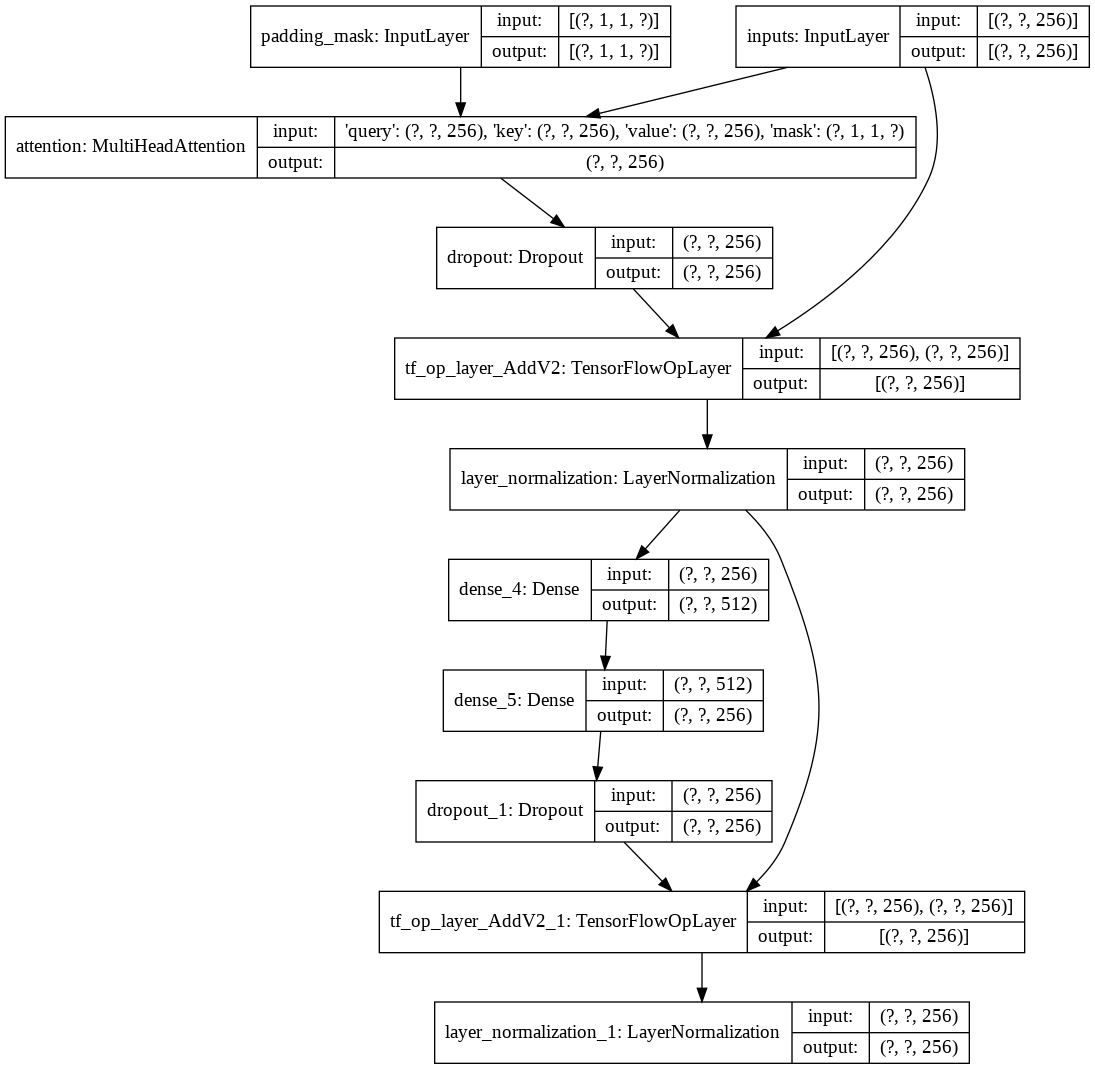

In [ ]:
sample_encoder_layer = encoder_layer(units=512,
                                     d_model=256, 
                                     num_heads=2, 
                                     dropout=0.5,
                                     activation='relu',
                                     name='sample_encoder_layer')

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder

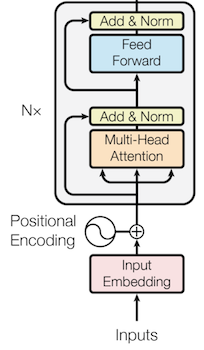

*Encoder Layer Illustration  from [Attention Is All You Need](https://arxiv.org/abs/1706.03762)*

The Encoder in the model consists of the following:
*  Input embedding layer
*  Positional encoding layer
*  Specified (Nx) number of Encoder Layers 

The input is put through an **embedding** layer. Embedding breathes meaning into the tokenised vectors by encoding them so that words that are closer in meaning appear closer to each other in the vector space. 

The embedding output vectors are then summed with the **positional encoding**. The result of this summation is fed as input into the **encoder layers**.  The output from the encoder layers serves as input into the decoder. 

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            activation,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, dtype=tf.float32))
  embeddings = PositionalEncoding(vocab_size,
                                  d_model)(embeddings)

  outputs = layers.Dropout(dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(units, d_model, num_heads, dropout, activation,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

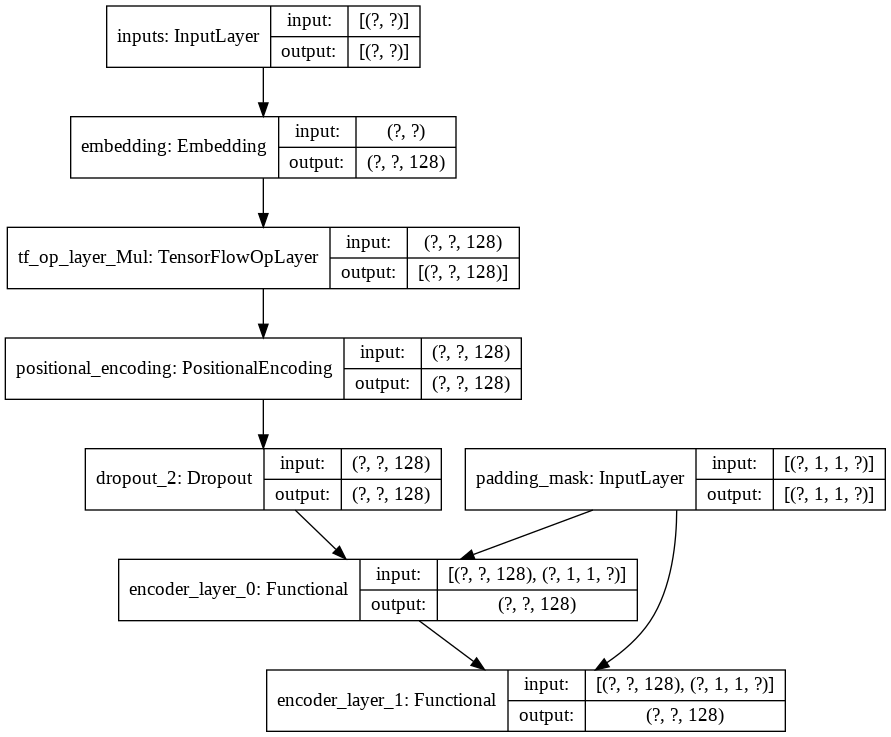

In [ ]:
sample_encoder = encoder(
            vocab_size=VOCAB_SIZE,
            num_layers=2, 
            units=512,
            d_model=128,
            num_heads=4,
            dropout=0.5,
            activation='relu',
            name="sample_encoder")

tf.keras.utils.plot_model(
    sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each of the Nx decoder layers has the following sub-layers:

*  Multihead attention with padding mask and look-ahead mask that receives the target as input, followed by a normalisation layer

*  Multi-head attention with padding mask that receives the value and key from the encoder input and the query from the output of the first multi-head attention layer. 

*  Nx Dense layers followed by a dropout- and normalisation layers

The decoder receives attention weights from the encoder output as well as attention paid to it's own input,  so the attention is a combination of the two. So when the decoder predicts the next word, it does so by looking at the encoder output and by paying attention to its own output. 

In [ ]:
def decoder_layer(units, 
                  d_model, 
                  num_heads, 
                  dropout, 
                  activation,
                  name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(
      shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 += tf.cast(inputs, dtype=tf.float32)
  attention1 = layers.LayerNormalization(epsilon=1e-6)(attention1)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,    #from multi-head attention1
          'key': enc_outputs,     #from encoder output
          'value': enc_outputs,   #from encoder output
          'mask': padding_mask
      })
  attention2 = layers.Dropout(dropout)(attention2)
  attention2 += attention1
  attention2 = layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  outputs = layers.Dense(
      units, activation=activation)(attention2)
  outputs = layers.Dense(d_model)(outputs)
  outputs = layers.Dropout(dropout)(outputs)
  outputs += attention2
  outputs = layers.LayerNormalization(epsilon=1e-6)(outputs)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

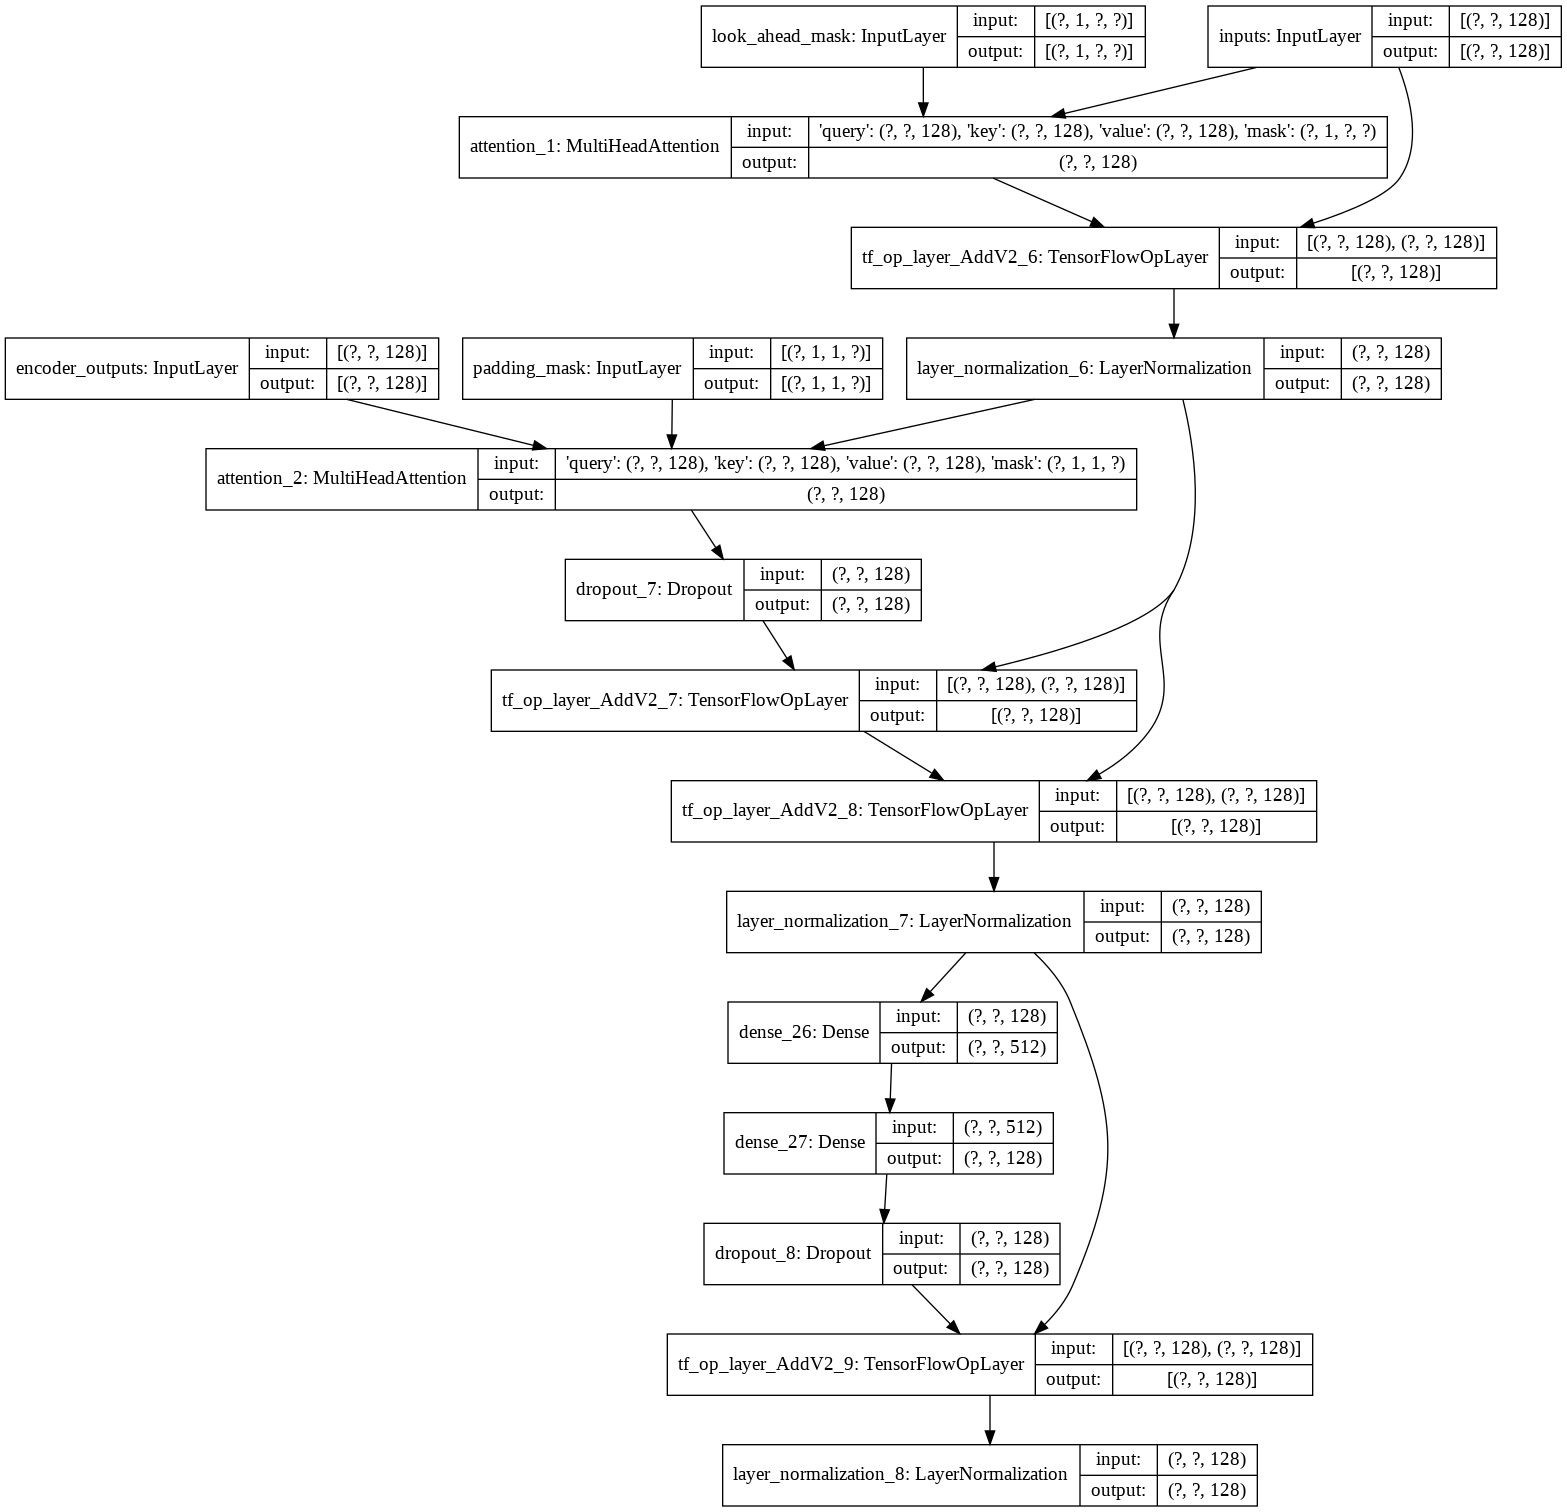

In [ ]:
sample_decoder_layer = decoder_layer(
                units=512, 
                d_model=128, 
                num_heads=4, 
                dropout=0.5, 
                activation='relu',
                name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

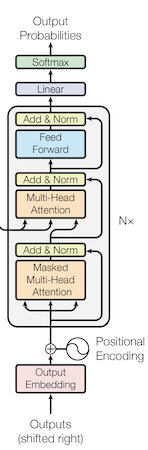

The decoder consists of the following layers:

*  Output embedding layer 
*  Positional encoding
*  Nx decoder layers

The target is put through the output embedding layer and summed with the positional encoding layer.  This feeds into Nx number of decoder layers.   

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            activation, 
            name="decoder"):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(
      shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, dtype=tf.float32))
  embeddings = PositionalEncoding(vocab_size,
                                  d_model)(embeddings)

  outputs = layers.Dropout(dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(units, d_model, num_heads, dropout, activation,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


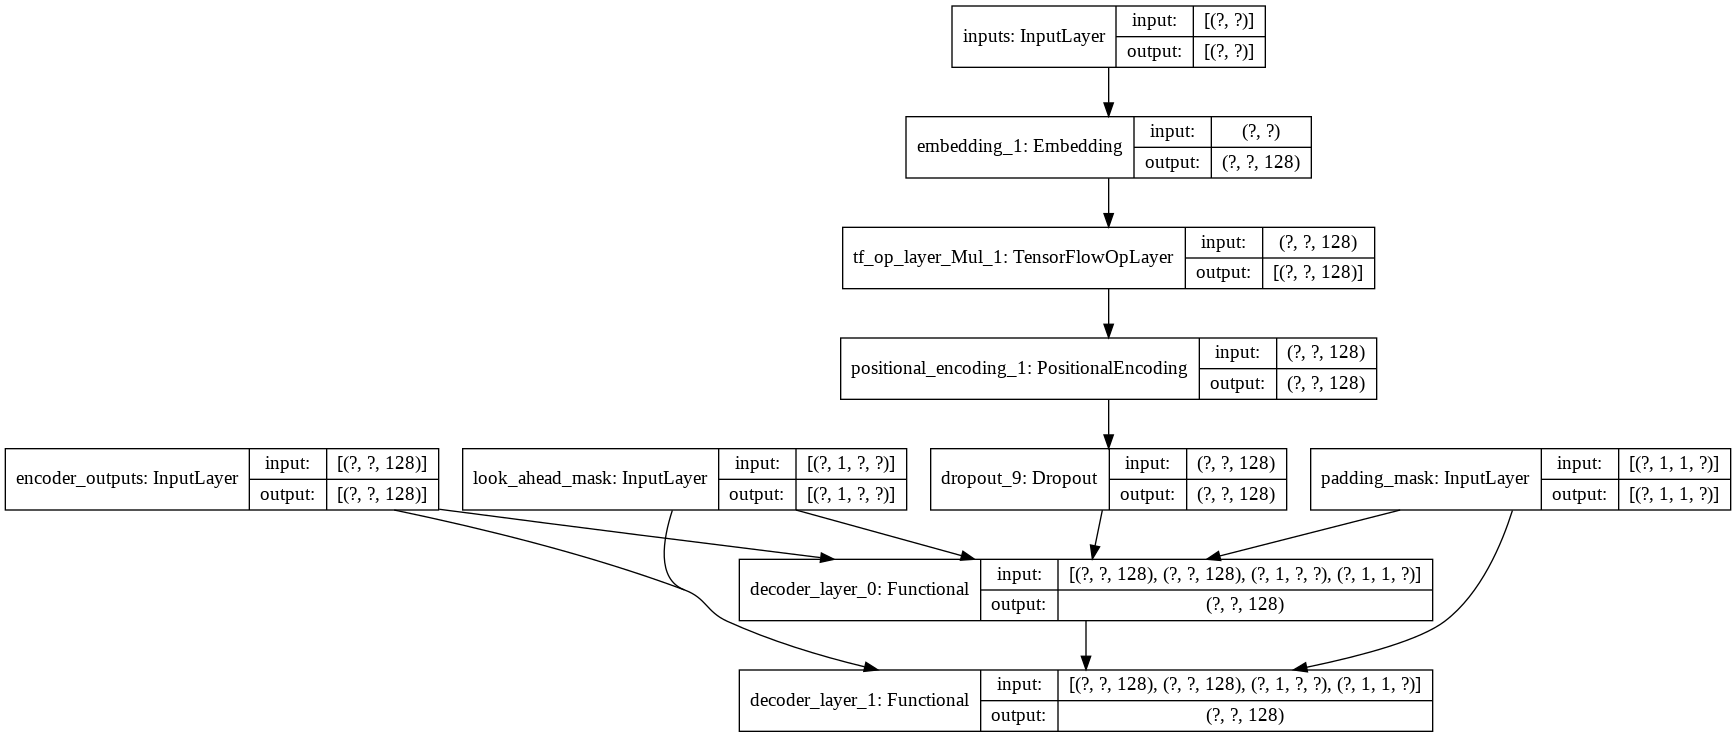

In [ ]:
sample_decoder = decoder(
            vocab_size=VOCAB_SIZE,
            num_layers=2,
            units=512,
            d_model=128,
            num_heads=4,
            dropout=0.5,
            activation='relu',
            name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

The transformer model consists of an encoder, a decoder and a final linear layer.  

The encoder output as well as the target values are fed into the decoder.  Once processed through the decoder, the output is put through the final linear layer and a softmax functioin determines the resulting probability.  


In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                activation,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(vocab_size, num_layers, units, d_model, num_heads, dropout,
            activation)(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(vocab_size, num_layers, units, d_model, num_heads, dropout,
            activation)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = layers.Dense(vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


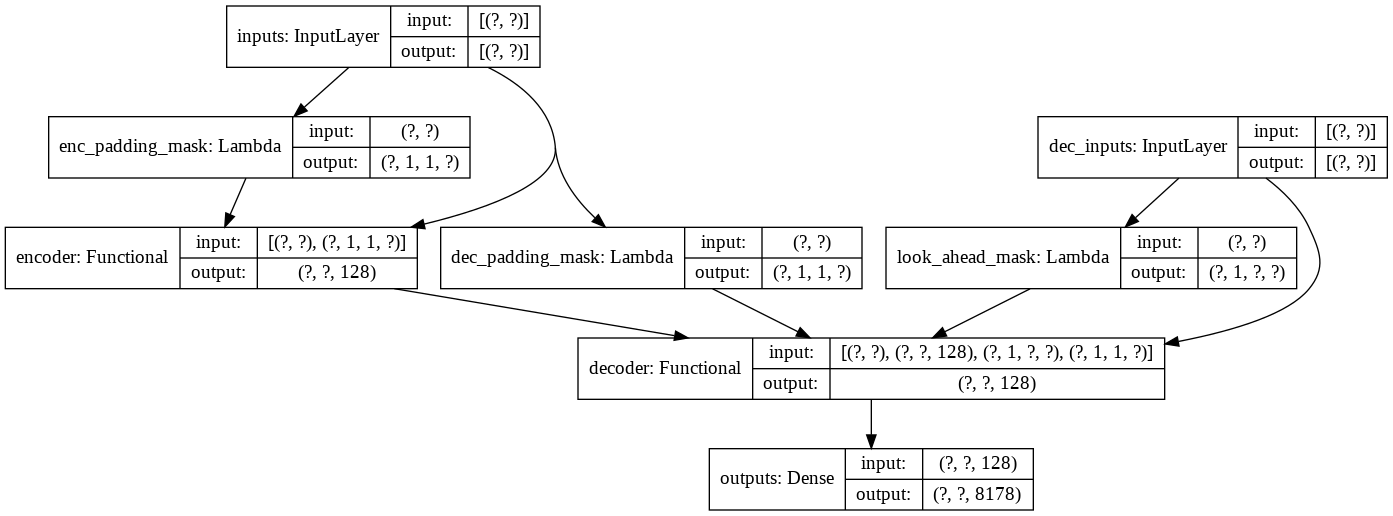

In [ ]:
sample_transformer = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    activation='relu', 
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Run the Chatbot

### Loss Function

Since the target values are padded, it is important to apply masking when calculating the loss. Therefor we write a seperate loss function. 

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

### Custom Learning Rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = tf.cast(d_model, dtype=tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * self.warmup_steps**-1.5
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

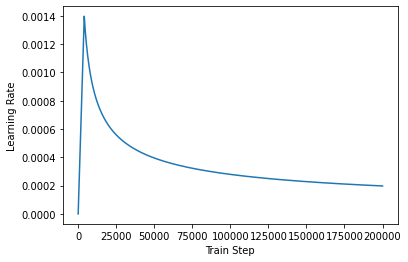

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Initialise & Compile Model

In [ ]:
#clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9,
                                     beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

#initialise and compile model with strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT, 
        activation=ACTIVATION)

model.compile(optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147776     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [ ]:
type(model.loss)

function

### Train Model

Train the model by calling model.fit()

In [ ]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/30
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   1/1029 [..............................] - ETA: 3:54:31 - loss: 2.7240 - accuracy: 4.0064e-04WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0077s vs `on_train_batch_end` time: 0.0315s). Check your callbacks.


1029/1029 [==============================] - 69s 67ms/step - loss: 1.9082 - accuracy: 0.0554
Epoch 2/30
1029/1029 [==============================] - 40s 39ms/step - loss: 1.4158 - accuracy: 0.0848
Epoch 3/30
1029/1029 [==============================] - 44s 43ms/step - loss: 1.3311 - accuracy: 0.0911
Epoch 4/30
1029/1029 [==============================] - 39s 38ms/step - loss: 1.2719 - accuracy: 0.0954
Epoch 5/30
1029/1029 [==============================] - 40s 39ms/step - loss: 1.2131 - accuracy: 0.0996
Epoch 6/30
1029/1029 [==============================] - 39s 38ms/step - loss: 1.1429 - accuracy: 0.1060
Epoch 7/30
1029/1029 [==============================] - 40s 39ms/step - loss: 1.0763 - accuracy: 0.1132
Epoch 8/30
1029/1029 [==============================] - 39s 38ms/step - loss: 1.0125 - accuracy: 0.1205
Epoch 9/30
1029/1029 [==============================] - 40s 38ms/step - loss: 0.9517 - accuracy: 0.1285
Epoch 10/30
1029/1029 [==============================] - 40s 39ms/step - lo

## Evaluate Model

With the model built and trained it is now time to **evaluate the quality** of the **text generation ability** of the  model.  

We feed an input utterance/sentence into the model which in turn generates a conditional probability distribution over the vocabulary of tokens according to the given input sequence.

###  Natural Language Generation Overview

The basic steps to generate text using our trained chatbot are listed below:

**Step 1**: Provide a sentence (with multiple words) to the chatbot as input

**Step 2**: The chatbot outputs a conditional probability distribution over words in the vocabulary

**Step 3**: We **sample** a word from the distribution using one of a number of sampling methods

**Step 4**: Next we concatenate the newly sampled word to the generated text

**Step 5**: Now a new input sequence is genereted by appending the newly sampled word, untill the newly sampled word is the END TOKEN, at which point we stop the generation of text. 

### Sampling Overview

In text generation, sampling refers to the process of selecting the next token from the generated condition probability distribution.  

So after generating the conditional probability distribution over the vocabulary for the given input sentence, we now need to decide **how** to select the next token from this distribution.   

There are several methods for selecting the next token including, but not limited to greedy search, temperature sampling, top k sampling, top p sampling and beam search. 

The question we will attempt to answer is to what extent the sampling method influences the quality output we can generate out of our model.  In this project we will explore **greedy search** and **top k sampling** and compare the results.   



### Inference Overview

A quick overview of the inference process:

**Step 1**: Take the input sequence and apply the same preprocessing function as we used when preparing the train dataset from the movie corpus. 

**Step 2**: Convert the preprocessed sequence into tokens using the tokeniser and add the START_TOKEN and END_TOKEN to the tokenised input sequence. 

**Step 3**: Calculate the padding- and look ahead masks. 

**Step 4**: Feed the resulting sequence to the encoder- decoder architecture to get a probability distribution over the vocabulary.

**Step 5**: Select the next predicted token based on the selected **sampling method**.  

**Step 6**: Add the predicted token to the generated sequence and pass it back to the decoder.

**Step 7**: Now the decoder predicts the next token based on it's previous predictions.  This process stops when the predicted token is the END_TOKEN. 


### Greedy Search Sampling

The **greedy search** method simply select the next token (word in our chatbot) by taking the **highest probability** from the distribution.  

Here we follow the inference process described above and at **step 5** we select the token with the highest probability, in other words we calculate the **argmax** of the distribution.

#### Inference

In [ ]:
def inference(start_token, end_token, max_length, model, tokenizer, sentence):
    #preprocess the sentence
    sentence = preprocess_sentence(sentence)
    #add start- & end tokens and to tokenised sentence
    sentence = tf.expand_dims(
      start_token + tokenizer.encode(sentence) + end_token,
      axis=0)

    output = tf.expand_dims(start_token, 0)

    for i in range(max_length):
        predictions = model(inputs=[sentence, output], training=False)
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, end_token[0]):
            break
        #print(predicted_id)
        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
        #print(tf.squeeze(output, axis=0))

    return tf.squeeze(output, axis=0)


#### Predict

In [ ]:
def predict(sentence):
  prediction = inference(START_TOKEN, END_TOKEN, MAX_LENGTH, model, tokenizer, sentence)
  #print(type(prediction))
  #print(prediction)
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  return predicted_sentence


#### Evaluate

**Example 1**

For the first examples we will use short and relatively simple sentences and we will request a single output response. 

In [ ]:
print('\nEvaluate')
sentence = 'I am hungry.'
output  = predict(sentence)
print('input: {}\noutput: {}'.format(sentence, output))
print(type(output))


Evaluate
input: I am hungry.
output: i am sorry . i really should not be weird .
<class 'str'>


In [ ]:
print('\nEvaluate')
sentence = 'Can you recommend a good movie ?'
output  = predict(sentence)
print('input: {}\noutput: {}'.format(sentence, output))



Evaluate
input: Can you recommend a good movie ?
output: i will use the toke .


In [ ]:
print('\nEvaluate')
sentence = 'I would like to read a good book and drink a pina colada '
output  = predict(sentence)
print('input: {}\noutput: {}'.format(sentence, output))
print(type(output))


Evaluate
input: I would like to read a good book and drink a pina colada 
output: how about that ?
<class 'str'>


**Example 2**

These are longer, slightly more complex sentences.  We will still only request a single response from the model.

Here we have a famous quote from the movie *Clueless*. 

**Cher**: *'You see how picky I am about my shoes and they only go on my feet'*.

In [ ]:
print('\nEvaluate')
sentence = "You See How Picky I Am About My Shoes And They Only Go On My Feet."
output = predict(sentence)
print('input: {}\noutput: {}'.format(sentence, output))



Evaluate
input: You See How Picky I Am About My Shoes And They Only Go On My Feet.
output: you are the one who found you would like to be .


**Example 3**

For the third example we will use a single input but generate **more than one**  consecutive responses.  We will use the output of the previous iteration as input to the next prediction. 

In [ ]:
sentence = "Let's grab lunch tomorrow and discuss this further."
for _ in range(7):
    output = predict(sentence)
    print('\ninput: {}\noutput: {}'.format(sentence, output))
    sentence = output


input: Let's grab lunch tomorrow and discuss this further.
output: there are two people in this world for all c power over this country even is a man ? what if there will not be any of us ?

input: there are two people in this world for all c power over this country even is a man ? what if there will not be any of us ?
output: we are not having ourselves . . . the childs of the 

input: we are not having ourselves . . . the childs of the 
output: but with what . . .

input: but with what . . .
output: i do not know what you are talking about .

input: i do not know what you are talking about .
output: you know what i mean . i know what happened .

input: you know what i mean . i know what happened .
output: i do not know , i just feel like everybody but i have got money . i can take it for her .

input: i do not know , i just feel like everybody but i have got money . i can take it for her .
output: you are so good to me .


In [ ]:
sentence = "Why are you late ?"
for _ in range(7):
    output = predict(sentence)
    print('\ninput: {}\noutput: {}'.format(sentence, output))
    sentence = output


input: Why are you late ?
output: i do not want you to get us anything .

input: i do not want you to get us anything .
output: you are going to be fine . i want to start one of those own people .

input: you are going to be fine . i want to start one of those own people .
output: well , i guess i will just be home after all . will you marry this guy with a living ?

input: well , i guess i will just be home after all . will you marry this guy with a living ?
output: i do not think so .

input: i do not think so .
output: you are a virgin !

input: you are a virgin !
output: i do not see what i can do to perfect .

input: i do not see what i can do to perfect .
output: i am thinking the del amo would be a sabp re looking happy .


In [ ]:
sentence = 'I would like to read a good book and drink a pina colada '
for _ in range(5):
    output = predict(sentence)
    print('\ninput: {}\noutput: {}'.format(sentence, output))
    sentence = output


input: I would like to read a good book and drink a pina colada 
output: how about that ?

input: how about that ?
output: you know , when you came on and my tracks it is with a motherfucker . you always been closely . . .

input: you know , when you came on and my tracks it is with a motherfucker . you always been closely . . .
output: we are not going to hurt her . we need the auxiliary you . we need our help .

input: we are not going to hurt her . we need the auxiliary you . we need our help .
output: aw , shucks , ma am . t were not you to tell them .

input: aw , shucks , ma am . t were not you to tell them .
output: i do not know what you are talking about .


In [ ]:
sentence = "I do not like Tony"
for _ in range(7):
    output = predict(sentence)
    print('\ninput: {}\noutput: {}'.format(sentence, output))
    sentence = output


input: I do not like Tony
output: you do not want to leave ?

input: you do not want to leave ?
output: i do not know . i want to go out .

input: i do not know . i want to go out .
output: you are not going to hurt me . i want to be with you now .

input: you are not going to hurt me . i want to be with you now .
output: i will be all right . i will be on the phone right by the back girl who will be able to help . try to make some money .

input: i will be all right . i will be on the phone right by the back girl who will be able to help . try to make some money .
output: are you hungry ?

input: are you hungry ?
output: i am having some things . and , i am the only woman , sea .

input: i am having some things . and , i am the only woman , sea .
output: i will get it to you , but you are the boss of all the sure .


#### Results

When we look at a single response to a relatively short sentence using greedy search, the responses are mostly grammatically sound and even sounds 'human like'.  It is very generic though - so the response does not 'convey' that it really 'understood' the utterance.  

When given a longer more complex input sentence, the grammer starts to suffer a little but some sense can still be made of it. 

When we ask the model to generate more than one response to an utterance, the model does not perform well. Although the immediate response is decent quality, the conversation is too generic and does not stay on topic. 

Greedy search also limits the responses, for example the phrase 'how about that' is repeated in a number of the examples.  

So just like greed is not good in any other area of life, it proves to be true in text generation as well.  


### Top K Sampling

The Top K Sampling method introduces a simple yet surprisingly effective sampling method, introduced in [this paper](https://arxiv.org/abs/1805.04833)

In Top K Sampling, the top K most likely words are filtered out and the probability mass is redistributed among only those k next words. 

To apply Top K sampling we take all probabilities, sort them from largest to smallest, take only the top K tokens and zero out the rest of the tokens.  Once we have the probabilities of the K words, we apply a softmax and select randomly from the K probabilities. 

The k-value is a chosen value and a broad distribution (many k values) will perform differently from a narrow distribution (fewer k values). 

We will use a couple of different k-values.  

#### Softmax

In [ ]:
def softmax(z):
    z = z.tolist()
    return np.exp(z)/sum(np.exp(z))

#### Top K Inference

In [ ]:
def top_k_inference(start_token, end_token, 
                    max_length, model, tokenizer, 
                    k, sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(40):

        predictions = model(inputs=[sentence, output], training=False)
        predictions = predictions[:, -1, :]

        top_k_probabilities, top_k_indices = tf.math.top_k(
            predictions, k, sorted=True)
        
        top_k_indices = np.asarray(top_k_indices).astype('int32')
        top_k_indices = top_k_indices.reshape(-1)

        top_k_probabilities = np.asarray(top_k_probabilities).astype('float32')
        top_k_probabilities = top_k_probabilities.reshape(-1)

        top_k_redistr_prob = softmax(top_k_probabilities)

        top_k_redistr_prob = top_k_redistr_prob.reshape(-1)
        sampled_token = np.random.choice(top_k_indices, p=top_k_redistr_prob)
        
        if sampled_token == END_TOKEN:
            break

        sampled_token = tf.convert_to_tensor(sampled_token.reshape(1,1), dtype=tf.int32)
        output = tf.concat([output, sampled_token], axis=-1)

    return tf.squeeze(output, axis=0)

#### Top K Predict

In [ ]:
def predict_top_k(sentence, k):
    output = top_k_inference(START_TOKEN, END_TOKEN, 
                               MAX_LENGTH, model, tokenizer, 
                               k, sentence)
    response = tokenizer.decode([i for i in output if i<tokenizer.vocab_size])
    return response

#### Top K Evaluate 

**Example 1**

Similar to greedy search and in order to compare, we will use a short and relatively simple sentence and request a single output response. 

**K = 3**

In [ ]:
sentence = 'I am hungry.'
print('\nEvaluate:')
output_top_k_3 = predict_top_k(sentence, 3)
print('Top K Sampling - 3 samples\n input:   {} \noutput:  {}'.format(sentence, output_top_k_3))



Evaluate:
Top K Sampling - 3 samples
 input:   I am hungry. 
output:  i am sorry , sir . i am a little me camped but


**K = 4**

In [ ]:
sentence = 'I am hungry'
print('\nEvaluate:')
output_top_k_4 = predict_top_k(sentence, 4)
print('Top K Sampling - 4 samples\n input:   {} \noutput:  {}'.format(sentence, output_top_k_4))


Evaluate:
Top K Sampling - 4 samples
 input:   I am hungry 
output:  you know how i feel about you and i am a student .


**K = 6**

In [ ]:
sentence = 'I am hungry'
print('\nEvaluate:')
output_top_k_6 = predict_top_k(sentence, 6)
print('Top K Sampling - 6 samples\n input:   {} \noutput:  {}'.format(sentence, output_top_k_6))



Evaluate:
Top K Sampling - 6 samples
 input:   I am hungry 
output:  it is okay , honey . i am okay .


**Example 2**
As with greedy search we use the same longer, slightly more complex sentence.  We will still only request a single response. 

We will again us the quote from the  movie *Clueless*. 

**Cher**: *'You see how picky I am about my shoes and they only go on my feet'*.

**K = 3**

In [ ]:
print('\nEvaluate:')
sentence = "You See How Picky I Am About My Shoes And They Only Go On My Feet."

output_top_k_3 = predict_top_k(sentence, 3)
print('Top K Sampling - 3 samples\n input:   {}\noutput:  {}'.format(sentence, output_top_k_3))



Evaluate:
Top K Sampling - 3 samples
 input:   You See How Picky I Am About My Shoes And They Only Go On My Feet.
output:  you are welcome to one of these . mistakes you and saw these people here you get the shot your way down on the way to the fucking room .


In [ ]:

print('\nEvaluate:')
sentence = 'I would like to read a good book and drink a pina colada '

output_top_k_3 = predict_top_k(sentence, 3)
print('Top K Sampling - 3 samples\n input:   {}\noutput:  {}'.format(sentence, output_top_k_3))




Evaluate:
Top K Sampling - 3 samples
 input:   I would like to read a good book and drink a pina colada 
output:  how about beautiful city ? do not you remember ?


**K = 4**

In [ ]:
print('Evaluate:')
sentence = "You See How Picky I Am About My Shoes And They Only Go On My Feet."

output_top_k_4 = predict_top_k(sentence, 4)
print('Top K Sampling - 4 samples\n input:   {}\noutput:  {}'.format(sentence, output_top_k_4))


Evaluate:
Top K Sampling - 4 samples
 input:   You See How Picky I Am About My Shoes And They Only Go On My Feet.
output:  sure . you could help me . you started out just a minute .


In [ ]:
print('Evaluate:')
sentence = "I would like to read a good book and drink a pina colada "

output_top_k_4 = predict_top_k(sentence, 4)
print('Top K Sampling - 4 samples\n input:   {}\noutput:  {}'.format(sentence, output_top_k_4))


Evaluate:
Top K Sampling - 4 samples
 input:   I would like to read a good book and drink a pina colada 
output:  how about that ?


**K = 6**

In [ ]:
print('Evaluate:')
sentence = "You See How Picky I Am About My Shoes And They Only Go On My Feet."

output_top_k_6 = predict_top_k(sentence, 6)
print('Top K Sampling - 6 samples\n input:   {}\noutput:  {}'.format(sentence, output_top_k_6))


Evaluate:
Top K Sampling - 6 samples
 input:   You See How Picky I Am About My Shoes And They Only Go On My Feet.
output:  your mother got hurt . do not even know where my life .


In [ ]:
print('Evaluate:')
sentence = "I would like to read a good book and drink a pina colada "

output_top_k_6 = predict_top_k(sentence, 6)
print('Top K Sampling - 6 samples\n input:   {}\noutput:  {}'.format(sentence, output_top_k_6))


Evaluate:
Top K Sampling - 6 samples
 input:   I would like to read a good book and drink a pina colada 
output:  good night , john .


**Example 3**

For our third example we will again, as with greedy search, use a single input but generate 5 consecutive responses.  We will use the output of the previous iteration as input to the next prediction. 

**K = 3**

In [ ]:
sentence = "Let's grab lunch tomorrow and discuss this further."
print('Top K Sampling - 3 samples')
for _ in range(5):
    output_top_k_3 = predict_top_k(sentence, 3)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_3))
    sentence = output_top_k_3

Top K Sampling - 3 samples

input:   Let's grab lunch tomorrow and discuss this further.
output:   there are more than you know . there s no other way there . . . here is god s sakes , if they find this way . . .

input:   there are more than you know . there s no other way there . . . here is god s sakes , if they find this way . . .
output:   i am afraid they cannot be such a dorritate like this . some anyway , the president . then even sent came to the most ional process was live into africa .

input:   i am afraid they cannot be such a dorritate like this . some anyway , the president . then even sent came to the most ional process was live into africa .
output:   my god , my mom always before me , me , doctor .

input:   my god , my mom always before me , me , doctor .
output:   i would love to hear you say that .

input:   i would love to hear you say that .
output:   i love you , my son ! i love you ! i love you ! i love you ! i love you ! i love you here ! i love you ! i love y

In [ ]:
sentence = "I would like to read a good book and drink a pina colada "
print('Top K Sampling - 3 samples')
for _ in range(5):
    output_top_k_3 = predict_top_k(sentence, 3)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_3))
    sentence = output_top_k_3    

Top K Sampling - 3 samples

input:   I would like to read a good book and drink a pina colada 
output:   how about a  ?

input:   how about a  ?
output:   i am fine . i just  . . .

input:   i am fine . i just  . . .
output:   you know , you get your stuff , before you get inside me .

input:   you know , you get your stuff , before you get inside me .
output:   no .

input:   no .
output:   what do you mean , sir ?


**K = 4**

In [ ]:
sentence = "Let's grab lunch tomorrow and discuss this further."
print('Top K Sampling - 4 samples')
for _ in range(5):
    output_top_k_4 = predict_top_k(sentence, 4)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_4))
    sentence = output_top_k_4

Top K Sampling - 4 samples

input:   Let's grab lunch tomorrow and discuss this further.
output:   there are more than you know . i would not put our secret in the wrong day .

input:   there are more than you know . i would not put our secret in the wrong day .
output:   and when in the library before it came up before they came here from here , then leave everything in except there with us .

input:   and when in the library before it came up before they came here from here , then leave everything in except there with us .
output:   how do you feel that ?

input:   how do you feel that ?
output:   i do not know . maybe i will see if you are right .

input:   i do not know . maybe i will see if you are right .
output:   you are the one who found the guy .


In [ ]:
sentence = "I would like to read a good book and drink a pina colada "
print('Top K Sampling - 4 samples')
for _ in range(5):
    output_top_k_4 = predict_top_k(sentence, 4)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_4))
    sentence = output_top_k_4

Top K Sampling - 4 samples

input:   I would like to read a good book and drink a pina colada 
output:   so how about you ?

input:   so how about you ?
output:   i do not know . . . okay . i guess .

input:   i do not know . . . okay . i guess .
output:   how about tomorrow ? you do not mean to be able to get off to some number , he is going to do some high favors and scared you need ?

input:   how about tomorrow ? you do not mean to be able to get off to some number , he is going to do some high favors and scared you need ?
output:   a friend . you know what . my land . . .asked the fontainbler to tell

input:   a friend . you know what . my land . . .asked the fontainbler to tell
output:   i told you to find out what was happening . . .


In [ ]:
sentence = "You See How Picky I Am About My Shoes And They Only Go On My Feet."
print('Top K Sampling - 4 samples')
for _ in range(5):
    output_top_k_4 = predict_top_k(sentence, 4)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_4))
    sentence = output_top_k_4

Top K Sampling - 4 samples

input:   You See How Picky I Am About My Shoes And They Only Go On My Feet.
output:   you are a beautiful girl , mrs . robinson . that will take me now .

input:   you are a beautiful girl , mrs . robinson . that will take me now .
output:   you are just going to love me , jake . you have got to trust me . you never see how i love you when you have all over the days over .

input:   you are just going to love me , jake . you have got to trust me . you never see how i love you when you have all over the days over .
output:   oh , i will do that .

input:   oh , i will do that .
output:   i do not want you to hurt you . that is all i want is an interesting pastrami almost have

input:   i do not want you to hurt you . that is all i want is an interesting pastrami almost have
output:   it is a more good to you mad


**K = 6**

In [ ]:
sentence = "Let's grab lunch tomorrow and discuss this further."
print('Top K Sampling - 6 samples')
for _ in range(5):
    output_top_k_6 = predict_top_k(sentence, 6)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_6))
    sentence = output_top_k_6

Top K Sampling - 6 samples

input:   Let's grab lunch tomorrow and discuss this further.
output:   there are days

input:   there are days
output:   a drink ?

input:   a drink ?
output:   i am so glad we got it there .

input:   i am so glad we got it there .
output:   it is nice .

input:   it is nice .
output:   i would like to buy you some way out of town for a while .


In [ ]:
sentence = "I would like to read a good book and drink a pina colada "
print('Top K Sampling - 5 samples')
for _ in range(5):
    output_top_k_5 = predict_top_k(sentence, 5)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k_5))
    sentence = output_top_k_5

Top K Sampling - 5 samples

input:   I would like to read a good book and drink a pina colada 
output:   how about that ?

input:   how about that ?
output:   i did not say . . .

input:   i did not say . . .
output:   you did not . . .

input:   you did not . . .
output:   i did not get killed another look . . .

input:   i did not get killed another look . . .
output:   that would be convenient .


In [ ]:
sentence = "You See How Picky I Am About My Shoes And They Only Go On My Feet."
print('Top K Sampling - 3 samples')
for _ in range(3):
    output_top_k = predict_top_k(sentence, 3)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k))
    sentence = output_top_k

Top K Sampling - 3 samples

input:   You See How Picky I Am About My Shoes And They Only Go On My Feet.
output:   you do not ? what is the story ?

input:   you do not ? what is the story ?
output:   i told her that you wanted to know she was a little saw the shot at her . you got her good come back there .

input:   i told her that you wanted to know she was a little saw the shot at her . you got her good come back there .
output:   what is that to my father ?


###Results from k-sampling

With short sentences and a relatively small k-value, the responses are once again good.  One improvement in k-sampling is that the responses are less generic and conveys more context. 

Longer sentences definitely keeps the context, for example *'reading a good book & drinking pina colada'* is associated with *'beautiful city'* in the response.  Also, an utterance referring to *being picky about shoes* picks up that there is a *story* to be told here.  

At times though, especially when k gets larger, the responses are long and become babbly and incoherent. 



#### Predict 3 sentences 

The current model seems to hit a sweet spot when we predict 3 consecutive sentences with both greedy search and k-sampling. 

Although greedy search still produces very generic responses the responses are 'conversation-like'.

K-sampling, though, produces responses that illustrates understanding of the context, as long as k is kept relatively small. 

In the examples below, the best result is achieved when k=3. A larger k-value produces incoherent, babbly responses that wonders off-topic.  

Predict 3 sentences with Greedy Search

In [ ]:
print('\nEvaluate')
sentence = 'I do not trust that lying thief with my secrets'

for _ in range(3):
    output = predict(sentence)
    print('\ninput: {}\noutput: {}'.format(sentence, output))
    sentence = output



Evaluate

input: I do not trust that lying thief with my secrets
output: i do not .

input: i do not .
output: you are not .

input: you are not .
output: i am not .


Predicting 3 sentences with K = 3

In [ ]:
sentence = "I do not trust that lying thief with my secrets"
print('Top K Sampling - 3 samples')
for _ in range(3):
    output_top_k = predict_top_k(sentence, 3)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k))
    sentence = output_top_k

Top K Sampling - 3 samples

input:   I do not trust that lying thief with my secrets
output:   i do not ! trust you ? no ! no you can trust me to come out .

input:   i do not ! trust you ? no ! no you can trust me to come out .
output:   i know you are not .

input:   i know you are not .
output:   you want to die ?


Predicting 3 sentences with K = 4

In [ ]:
sentence = "I do not trust that lying thief with my secrets"
print('Top K Sampling - 4 samples')
for _ in range(3):
    output_top_k = predict_top_k(sentence, 4)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k))
    sentence = output_top_k

Top K Sampling - 4 samples

input:   I do not trust that lying thief with my secrets
output:   i do not ! i love you , red .

input:   i do not ! i love you , red .
output:   but i . . . i love your father !

input:   but i . . . i love your father !
output:   i love you , my dear .


Predict 3 sentences with K = 5

In [ ]:
sentence = "I do not trust that lying thief with my secrets"
print('Top K Sampling - 5 samples')
for _ in range(3):
    output_top_k = predict_top_k(sentence, 5)
    print('\ninput:   {}\noutput:   {}'.format(sentence, output_top_k))
    sentence = output_top_k

Top K Sampling - 5 samples

input:   I do not trust that lying thief with my secrets
output:   i do not .

input:   i do not .
output:   you are a very unusual stenographer

input:   you are a very unusual stenographer
output:   or else .


Predict 3 sentences

In [ ]:
print('\nEvaluate')
sentence = "When will you learn to drive more responsibly ?"

for _ in range(3):
    output = predict(sentence)
    print('\ninput: {}\noutput: {}'.format(sentence, output))
    sentence = output



Evaluate

input: When will you learn to drive more responsibly ?
output: do not you think anyone can die

input: do not you think anyone can die
output: what the hell is so stupid about these things , father . . .

input: what the hell is so stupid about these things , father . . .
output: i am sorry , sir . i have no title top of what he says he is shot him for the dead .


# Conclusion

The transformer chatbot in this project provides a good baseline project from which improvements can be made.  

The model, although far from perfect, does serve as a good base model with potential to fine-tune hyperparameters, trained on a sub-set of the corpus including only certain characters and/or shows of trained on another corpus altogether. 